#  NERC task with CoNLL 2003

This is the first part of the task dedicated to reserching *Named Entity Recognition and Classification (NERC)* task applying to the *CoNLL 2003 dataset*. In this step we need find the best way to generate markup for the dataset in the subsequent steps. Also, we will experiment with prompt engineering.


## Dataset analysis

First of all, we need to import necessery libraries and download our dataset:

In [1]:
# !pip install datasets

In [2]:
from datasets import load_dataset
import pandas as pd
from collections import Counter, deque
import requests
from pprint import pprint
import os
import json
import random
import multiprocessing
import itertools
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import precision_score, recall_score, f1_score
from dataclasses import dataclass
import pickle

In [3]:
API_URL = "https://llm.ispras.ru/api/chat/completions"
API_MODEL_URL = "https://llm.ispras.ru/api/models"
API_KEY = "YOUR_TOKEN"
with open('./secrets') as file:
    data: dict = json.load(file)
    API_KEY = data.get('API_KEY', 'FAILED TO LOAD')

In [4]:
dataset = load_dataset("eriktks/conll2003")

Let's look at the information about the dataset. We have three splits: 'train', 'validation', 'test'.

`dataset.keys()` - to see what splits we have.


In [5]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})


Let's look at the first example in our dataset:

In [6]:
pprint(dataset["test"][666])


{'chunk_tags': [11, 13, 11, 12, 12],
 'id': '666',
 'ner_tags': [0, 0, 7, 0, 0],
 'pos_tags': [24, 15, 16, 16, 21],
 'tokens': ['Results', 'of', 'French', 'first', 'division']}


Evaluate the number of examples:

In [7]:
for split in dataset.keys():
    dataset_split = dataset[split]
    split_len = len(dataset_split)
    print(f"Split '{split}':  {split_len} examples.")


Split 'train':  14041 examples.
Split 'validation':  3250 examples.
Split 'test':  3453 examples.



### Entity Tags

The original dataset uses named entity recognition (NER) tags in the IOB2 format.

Each token is annotated with three types of tags:
1. POS Tags: Indicate the token's grammatical role (e.g., 'NN', 'VB', etc.).
2. Chunk Tags: Specify the syntactic chunk the token belongs to (e.g., 'B-NP', 'I-NP').
3. NER Tags: Identify named entities using the IOB2 scheme:
   - 'O'      : Token is not part of any entity.
   - 'B-PER'  : Beginning of a person entity.
   - 'I-PER'  : Inside a person entity.
   - 'B-ORG'  : Beginning of an organization entity.
   - 'I-ORG'  : Inside an organization entity.
   - 'B-LOC'  : Beginning of a location entity.
   - 'I-LOC'  : Inside a location entity.
   - 'B-MISC' : Beginning of a miscellaneous entity.
   - 'I-MISC' : Inside a miscellaneous entity.

In [8]:
POS_TAGS = {'"': 0, "''": 1, '#': 2, '$': 3, '(': 4, ')': 5, ',': 6, '.': 7, ':': 8, '``': 9, 'CC': 10, 'CD': 11, 'DT': 12,
 'EX': 13, 'FW': 14, 'IN': 15, 'JJ': 16, 'JJR': 17, 'JJS': 18, 'LS': 19, 'MD': 20, 'NN': 21, 'NNP': 22, 'NNPS': 23,
 'NNS': 24, 'NN|SYM': 25, 'PDT': 26, 'POS': 27, 'PRP': 28, 'PRP$': 29, 'RB': 30, 'RBR': 31, 'RBS': 32, 'RP': 33,
 'SYM': 34, 'TO': 35, 'UH': 36, 'VB': 37, 'VBD': 38, 'VBG': 39, 'VBN': 40, 'VBP': 41, 'VBZ': 42, 'WDT': 43,
 'WP': 44, 'WP$': 45, 'WRB': 46}

CHUNK_TAGS = {'O': 0, 'B-ADJP': 1, 'I-ADJP': 2, 'B-AfdsdDVP': 3, 'I-ADVP': 4, 'B-CONJP': 5, 'I-CONJP': 6, 'B-INTJ': 7, 'I-INTJ': 8,
 'B-LST': 9, 'I-LST': 10, 'B-NP': 11, 'I-NP': 12, 'B-PP': 13, 'I-PP': 14, 'B-PRT': 15, 'I-PRT': 16, 'B-SBAR': 17,
 'I-SBAR': 18, 'B-UCP': 19, 'I-UCP': 20, 'B-VP': 21, 'I-VP': 22}

NER_TAGS = {'O': 0, 'B-PER': 1, 'I-PER': 2, 'B-ORG': 3, 'I-ORG': 4, 'B-LOC': 5, 'I-LOC': 6, 'B-MISC': 7, 'I-MISC': 8}


Let's see the distribution of tags in the dataset:

In [9]:
def analyze_tags(dataset):
    pos_tags_counter = Counter()
    chunk_tags_counter = Counter()
    ner_tags_counter = Counter()
    
    for split in dataset.keys():
        for example in dataset[split]:
            pos_tags_counter.update(example["pos_tags"])
            chunk_tags_counter.update(example["chunk_tags"])
            ner_tags_counter.update(example["ner_tags"])
    
    print("POS Tags Distribution:", pos_tags_counter)
    print("Chunk Tags Distribution:", chunk_tags_counter)
    print("NER Tags Distribution:", ner_tags_counter)
    
    return pos_tags_counter, chunk_tags_counter, ner_tags_counter

pos_tags_counter, chunk_tags_counter, ner_tags_counter = analyze_tags(dataset)

POS Tags Distribution: Counter({22: 51545, 21: 34856, 11: 29962, 15: 28059, 12: 19773, 16: 17267, 24: 14580, 38: 12222, 7: 10898, 6: 10877, 37: 6304, 40: 5964, 30: 5852, 10: 5350, 35: 5193, 28: 4630, 4: 4233, 5: 4232, 39: 3769, 8: 3609, 42: 3439, 0: 3239, 27: 2323, 29: 2238, 41: 2132, 20: 1767, 23: 1010, 33: 784, 43: 769, 44: 769, 34: 642, 3: 622, 17: 579, 46: 551, 18: 388, 31: 259, 14: 228, 13: 210, 32: 62, 1: 60, 26: 47, 36: 42, 45: 41, 19: 37, 25: 5})
Chunk Tags Distribution: Counter({12: 99175, 11: 85016, 0: 40828, 13: 27706, 21: 26510, 22: 12902, 3: 3846, 17: 1931, 1: 1747, 15: 784, 2: 318, 4: 210, 14: 135, 7: 103, 9: 64, 6: 59, 5: 47, 18: 30, 10: 4, 16: 2, 8: 1})
NER Tags Distribution: Counter({0: 250660, 5: 10645, 1: 10059, 3: 9323, 2: 6991, 4: 5290, 7: 5062, 8: 1717, 6: 1671})


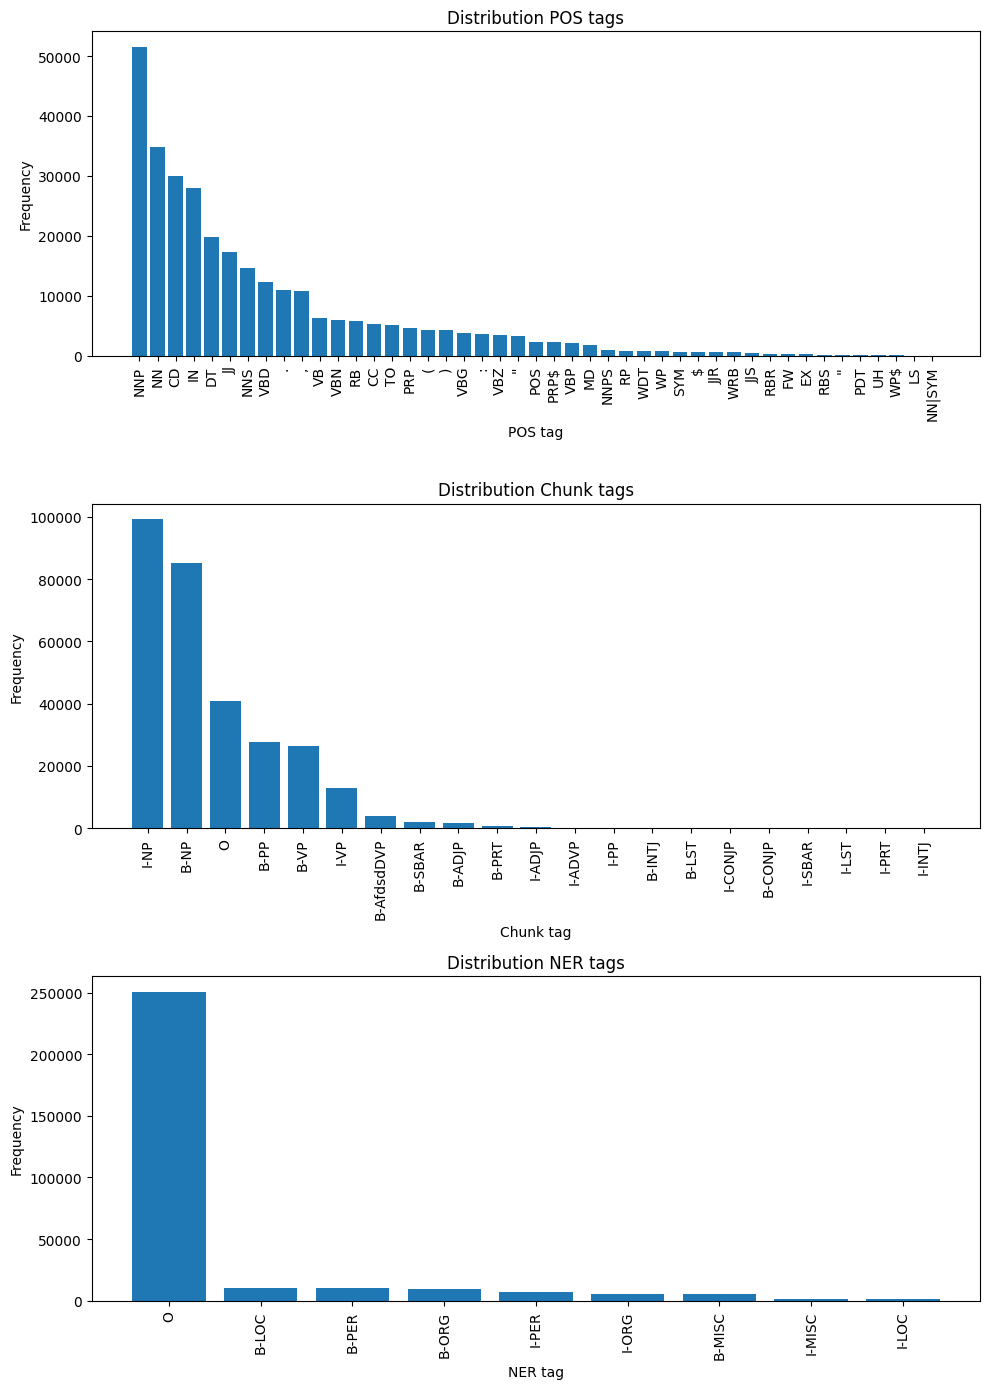

In [10]:
inv_pos_tags = {v: k for k, v in POS_TAGS.items()}
inv_chunk_tags = {v: k for k, v in CHUNK_TAGS.items()}
inv_ner_tags = {v: k for k, v in NER_TAGS.items()}

fig, axes = plt.subplots(3, 1, figsize=(10, 14))

pos_sorted = sorted(pos_tags_counter.items(), key=lambda x: x[1], reverse=True)
pos_keys, pos_values = zip(*pos_sorted)
pos_labels = [inv_pos_tags.get(k, str(k)) for k in pos_keys]

# POS tags
axes[0].bar(pos_labels, pos_values)
axes[0].set_title("Distribution POS tags")
axes[0].set_xlabel("POS tag")
axes[0].set_ylabel("Frequency")
axes[0].tick_params(axis='x', rotation=90)

chunk_sorted = sorted(chunk_tags_counter.items(), key=lambda x: x[1], reverse=True)
chunk_keys, chunk_values = zip(*chunk_sorted)
chunk_labels = [inv_chunk_tags.get(k, str(k)) for k in chunk_keys]

# Chunk tags
axes[1].bar(chunk_labels, chunk_values)
axes[1].set_title("Distribution Chunk tags")
axes[1].set_xlabel("Chunk tag")
axes[1].set_ylabel("Frequency")
axes[1].tick_params(axis='x', rotation=90)

# NER tags
ner_sorted = sorted(ner_tags_counter.items(), key=lambda x: x[1], reverse=True)
ner_keys, ner_values = zip(*ner_sorted)
ner_labels = [inv_ner_tags.get(k, str(k)) for k in ner_keys]

axes[2].bar(ner_labels, ner_values)
axes[2].set_title("Distribution NER tags")
axes[2].set_xlabel("NER tag")
axes[2].set_ylabel("Frequency")
axes[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

### Sentences in the dataset


Each sentence is split into tokens. 

In [11]:
dataset.data["train"]["tokens"][0]

<pyarrow.ListScalar: ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']>

To use sentences in model we need to group tokens to lists for each sentences with function `get_sentence`.

After generating we will have the batch with random sentences to send them to the model.

The function `generate_corps` takes dataset_


In [12]:
def get_sentence(dataset_name: str, idx: int) -> str: 
    return ' '.join(dataset.data[dataset_name]["tokens"][idx].values.tolist())

def generate_corps(size: int, dataset_name: str):
    data = dataset[dataset_name]
    data_size = data.shape[0]
    return (get_sentence(dataset_name, idx) 
            for idx in random.choices(range(data_size), k=size))

For example for batch of 10 random sentences:

```python
generate_corps(10, "train"), sep='\n'
```

we will have the batch of unannotated sentances.

```bash
delivered to consumer
shares outstanding
3 - Wayne Ferreira ( South Africa ) beat Jiri Novak ( Czech
LECIVA PRAHA 2470.00 2470.00 1360 3359.200
BOSTON AT CALIFORNIA
-- Helsinki Newsroom +358 - 0 - 680 50 245
More than 1,000 people have been executed in drug-related cases since the law took effect in 1989 .
In another scene , a young girl performed oral sex with an unidentified adult man .
Essex 532-8
ACC sold 9.4 million tonnes in 1995/96 , retaining its top position in the Indian cement industry , Palkhivala said .
```

In [13]:
print(*generate_corps(2, "train"), sep='\n')


Revenue from commuter traffic 5,400 up 4.6 pct
Police spokesman Roger Grimwade said the six or seven hijackers remained on board the aircraft , which arrived from Cyprus at 4.30 a.m. ( 0330 GMT ) .


## Model requests

To make the request to the models let's make the request's head and body. And see the available models list to use them further.

In [14]:
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

Retrieve all models names:



In [15]:
def get_all_model_names():
    headers = {"Authorization": f"Bearer {API_KEY}"}
    response = requests.get(API_MODEL_URL, headers=headers)
    if response.status_code // 100 == 2:
        data = response.json()
        models = data.get("data", [])
        model_names = [model["name"] for model in models]
        return model_names
    return None

In [16]:
model_names = get_all_model_names()

pprint(model_names)

['llama3.3:latest',
 'llama3.1:70b',
 'llama3.1:405b',
 'gemma2:27b',
 'mistral-large:123b',
 'command-r-plus:104b',
 'llama3.1:8b',
 'krith/qwen2.5-coder-32b-instruct:IQ3_M',
 'deepseek-coder-v2:236b',
 'llama3.2:latest',
 'mistral:7b',
 'RuadaptQwen2.5-32B-FuseO1:Q8',
 'RuadaptQwen2.5-32B-Pro-Beta:Q8',
 'RuadaptQwen2.5-32B-QWQ:Q8',
 'deepseek-r1:14b',
 'deepseek-r1:70b',
 'deepseek-r1:7b',
 'deepseek-r1:8b',
 'qwen2.5-coder:1.5b',
 'qwen2.5-coder:32b-instruct-q8_0']


To make the body of request we construct several prompts with different description of the task to the model.

In [17]:
# Classifies named entities without specifying tag types
prompt_1 = lambda sentence: f"Classify all named entities in a sentence and categorize their semantic meaning: '{sentence}'"

# Classifies entities using a predefined set of tags
prompt_2 = lambda sentence, tags: f"Classify all named entities in a sentence: '{sentence}', based on following tags: {tags}"

# Uses POS, Chunk, and NER tags for comprehensive token analysis
prompt_3 = lambda sentence, pos_tags, chunk_tags, ner_tags: f"Classify all named entities in a sentence: '{sentence}', \
based on following parts of speech tags: {pos_tags}, \
based on following chunk tags: {chunk_tags}, \
based on following named entity recognition tags: {ner_tags}"

# Assigns POS, Chunk, and NER tags to each token
prompt_4 = lambda sentence, pos_tags, chunk_tags, ner_tags: f"Determine each entity that can be classified and assign them a pos_tag, a chunk_tag and a ner_tag, using following lists: \
parts of speech tags: [{pos_tags}], \
chunk tags: [{chunk_tags}], \
named entity recognition tags: [{ner_tags}] from the following: '{sentence}'." 

# Splits entities into tokens and assigns tags at token level
prompt_4_1 = lambda sentence, pos_tags, chunk_tags, ner_tags: f"Determine each entity that can be classified, split it into tokens and assign them a pos_tag, a chunk_tag and a ner_tag, using following lists: \
parts of speech tags: [{pos_tags}], \
chunk tags: [{chunk_tags}], \
named entity recognition tags: [{ner_tags}] from the following: '{sentence}'." 

# Processes multiple sentences, assigning tags to all tokens
prompt_5 = lambda sentences, pos_tags, chunk_tags, ner_tags: f"""Determine each entity that can be classified and assign them a pos_tag, a chunk_tag and a ner_tag, using following lists: \
parts of speech tags: [{pos_tags}], \
chunk tags: [{chunk_tags}], \
named entity recognition tags: [{ner_tags}] from the following sentences: {', '.join(f"'{sentence}'" for sentence in sentences)}."""

# Returns JSON output with POS, Chunk, and NER tags
prompt_6 = lambda sentence, pos_tags, chunk_tags, ner_tags: f"""Identify each named entity in the sentence and classify it by the following tags:
    - POS tags: {pos_tags}
    - Chunk tags: {chunk_tags}
    - NER tags: {ner_tags}
    Sentence: '{sentence}'
    Return the response in JSON format with the fields: text, pos_tag, chunk_tag, ner_tag."""

# Analyzes token sequences, assigning tags with JSON output
prompt_7 = lambda tokens, pos_tags, chunk_tags, ner_tags: f"""Identify each named entity from the following sequence of tokens and classify it by the following tags:
    - POS tags: {pos_tags}
    - Chunk tags: {chunk_tags}
    - NER tags: {ner_tags}
    Tokens: '{", ".join(f"`{token}`" for token in tokens)}'
    Return the response in JSON format with the fields: text, pos_tag, chunk_tag, ner_tag."""

prompt_7_1 = lambda tokens, pos_tags, chunk_tags, ner_tags: f"""Identify each named entity from the following sequence of tokens and classify it by the following tags, each token is enquoted with "`" and "`" is not part of token:
    - POS tags: {pos_tags}
    - Chunk tags: {chunk_tags}
    - NER tags: {ner_tags}
    Tokens: '{", ".join(f"`{token}`" for token in tokens)}'
    Return the response in JSON format with the fields: tokens, pos_tags, chunk_tags, ner_tags.
    Each token has to be evaluated. The number of tags must match the number of tokens of each token type. 
    Example of the correct output:
    {{'chunk_tags': [11, 0, 11, 21, 11, 12, 0, 11, 13, 11, 12, 0],
    'ner_tags': [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'pos_tags': [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7],
    'tokens': ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.']}}"""

prompt_7_1_1 = lambda tokens, ner_tags: f"""Identify each named entity from the following sequence of tokens and classify it by the NER tags. Each token is enquoted with "`" and "`" is not part of token:
    - NER tags: {ner_tags}
    Tokens: '{", ".join(f"`{token}`" for token in tokens)}'
    Return the response in JSON format with the fields: ner_tags, tokens.
    Each token has to be evaluated. The number of tags must match the number of tokens of each token type. 
    Example of the correct output:
    {{'ner_tags': [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'tokens': ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.']}}"""


# Multiple token sequences with strict JSON formatting.
prompt_7_2 = lambda tokenss, pos_tags, chunk_tags, ner_tags: f"""Identify each named entity in each sequence of tokens from list of sequences of tokens and classify it by the following tags, each token is enquoted with "`" and "`" is not part of token and each sequence is enclosed in square brackets:
    - POS tags: {pos_tags}
    - Chunk tags: {chunk_tags}
    - NER tags: {ner_tags}
    Tokens: '{", ".join(f"[{', '.join(f'`{token}`' for token in tokens)}]" for tokens in tokenss)}'
    Return the response in JSON format as list of entries where entry has fields: pos_tags, chunk_tags, ner_tags, tokens.
    Each token has to be evaluated. The number of tags of each token type must match the number of tokens in each entry exactly.
    Example of the correct output:
    [
    {{'chunk_tags': [11, 0, 11, 21, 11, 12, 0, 11, 13, 11, 12, 0],
    'ner_tags': [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    'pos_tags': [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7],
    'tokens': ['SOCCER', '-', 'JAPAN', 'GET', 'LUCKY', 'WIN', ',', 'CHINA', 'IN', 'SURPRISE', 'DEFEAT', '.']}}, 
    {{'chunk_tags': [11, 13, 11, 12, 12],
    'ner_tags': [0, 0, 7, 0, 0],
    'pos_tags': [24, 15, 16, 16, 21],
    'tokens': ['Results', 'of', 'French', 'first', 'division']}}
    ]"""

# Expert task for multiple sequences with detailed JSON output
prompt_7_3 = lambda tokenss, pos_tags, chunk_tags, ner_tags: f"""
You are an expert in Named Entity Recognition (NER) and text annotation. Your task is to analyze each sequence of tokens, identify named entities, and classify them according to the following tags:

### Tags:
- **POS tags**: {pos_tags}
- **Chunk tags**: {chunk_tags}
- **NER tags**: {ner_tags}

### Input:
You are given a list of token sequences. Each token is enclosed in backticks (`), and each sequence is enclosed in square brackets. For example:
`[`token1`, `token2`], [`token3`, `token4`]`

### Task:
1. For each token sequence:
   - Analyze each token.
   - Assign a POS tag, a Chunk tag, and a NER tag to each token.
   - Ensure that the number of tags matches the number of tokens exactly.
2. Return the result in JSON format as a list of entries. Each entry must have the following fields:
   - `tokens`: List of tokens.
   - `pos_tags`: List of POS tags for each token.
   - `chunk_tags`: List of Chunk tags for each token.
   - `ner_tags`: List of NER tags for each token.

### Rules:
- Each token must be evaluated.
- The number of tags (POS, Chunk, NER) must match the number of tokens exactly.
- Use the provided tag mappings for classification.

### Example Input:
`[`SOCCER`, `-`, `JAPAN`, `GET`, `LUCKY`, `WIN`, `,`, `CHINA`, `IN`, `SURPRISE`, `DEFEAT`, `.`], [`Results`, `of`, `French`, `first`, `division`]`

### Example Output:
```json
[
    {{
        "tokens": ["SOCCER", "-", "JAPAN", "GET", "LUCKY", "WIN", ",", "CHINA", "IN", "SURPRISE", "DEFEAT", "."],
        "pos_tags": [21, 8, 22, 37, 22, 22, 6, 22, 15, 12, 21, 7],
        "chunk_tags": [11, 0, 11, 21, 11, 12, 0, 11, 13, 11, 12, 0],
        "ner_tags": [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    }},
    {{
        "tokens": ["Results", "of", "French", "first", "division"],
        "pos_tags": [24, 15, 16, 16, 21],
        "chunk_tags": [11, 13, 11, 12, 12],
        "ner_tags": [0, 0, 7, 0, 0]
    }}
]"""

# Only NER tagging for multiple sequences
prompt_7_4 = lambda tokenss, ner_tags: f"""
You are an expert in Named Entity Recognition (NER). Your task is to analyze each sequence of tokens, identify named entities, and classify them according to the following NER tags:

### NER Tags:
{ner_tags}

### Input:
You are given a list of token sequences. Each token is enclosed in backticks (`), and each sequence is enclosed in square brackets. For example:
`[`token1`, `token2`], [`token3`, `token4`]`

### Task:
1. For each token sequence:
   - Analyze each token.
   - Assign a NER tag to each token.
   - Ensure that the number of NER tags matches the number of tokens exactly.
2. Return the result in JSON format as a list of entries. Each entry must have the following fields:
   - `tokens`: List of tokens.
   - `ner_tags`: List of NER tags for each token.

### Rules:
- Each token must be evaluated.
- The number of NER tags must match the number of tokens exactly.
- Use the provided NER tag mappings for classification.

### Example Input:
`[`SOCCER`, `-`, `JAPAN`, `GET`, `LUCKY`, `WIN`, `,`, `CHINA`, `IN`, `SURPRISE`, `DEFEAT`, `.`], [`Results`, `of`, `French`, `first`, `division`]`

### Example Output:
```json
[
    {{
        "tokens": ["SOCCER", "-", "JAPAN", "GET", "LUCKY", "WIN", ",", "CHINA", "IN", "SURPRISE", "DEFEAT", "."],
        "ner_tags": [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
    }},
    {{
        "tokens": ["Results", "of", "French", "first", "division"],
        "ner_tags": [0, 0, 7, 0, 0]
    }}
]"""

# NER tagging for a single token sequence
prompt_8 = lambda tokens, ner_tags: f"""Identify each named entity from the following sequence of tokens and classify it by the NER tags:
    - NER tags: {ner_tags}
    Tokens: '{", ".join(f"`{token}`" for token in tokens)}'
    Return the response in JSON format with the fields: text, pos_tag, chunk_tag, ner_tag."""

# JSON output with text and NER tags only
prompt_9 = lambda tokens, ner_tags: f"""Analyze the following sequence of tokens to identify and classify each named entity using the provided NER tags. Follow these instructions precisely:
    NER Tags: {ner_tags}
    Tokens: '{", ".join(f"{token}" for token in tokens)}'
    Return your results as a valid JSON array. Each object in the array must include exactly two fields:

    text: The text of the identified named entity.
    ner_tag: The corresponding NER tag from the list provided.
    Do not include any extra information or commentary in your output."""

# JSON output with text and NER tags, emphasizing precision
prompt_10 = lambda tokens, ner_tags: f"""Perform Named Entity Recognition (NER) on the following sequence of tokens. Identify each named entity and classify it using the provided NER tags.
    NER Tags: {ner_tags}
    Tokens: {", ".join(f"'{token}'" for token in tokens)}
    Return the response in a structured JSON format with the following fields for each entity:
    text: The identified named entity (exact text from the tokens).
    ner_tag: The corresponding NER tag for the entity.
    Ensure the output is precise and adheres strictly to the provided NER tags and token sequence."""


Function to generate the request's payload, accepting prompt as an argument:

In [18]:
def perform_request(prompt: str, model: str = "llama3.3:latest"):
    payload = {
        "model": model,
        "messages": [{"role": "user", "content": prompt}],
        "format": "json"
    }
    try:
        response = requests.post(API_URL, headers=headers, json=payload)
        response.raise_for_status()
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Request failed: {e}")
        return None

def perform_requests_parallel(prompts, model: str = "llama3.3:latest"):
    with multiprocessing.Pool(10) as p:
        results = p.starmap(perform_request, [(prompt, model) for prompt in prompts])
    return results

The example response with prompt_4 we get using perform_request:

```python
single_sentence = tuple(generate_corps(1, "train"))
single_prompt = prompt_4(single_sentence, POS_TAGS, CHUNK_TAGS, NER_TAGS)

response = perform_request(single_prompt)
pprint(response)
pprint((json.loads(response["choices"][0]["message"]["content"]), single_prompt))
```

To make multiprocessing request to make the responces from model faster (if only not the server allow to perform requests from one API one-by-one).

```python
single_sentence = tuple(generate_corps(1, "train"))
single_prompt = prompt_4(single_sentence, POS_TAGS, CHUNK_TAGS, NER_TAGS)

response = perform_request(single_prompt)
pprint(response)
pprint((json.loads(response["choices"][0]["message"]["content"]), single_prompt))
```

Let's transform into dictionary the results we got from the prompt_5:

(In the prompt_5 we are trying to send to the model multiply sentences in a single request)

```python
pprint([(json.loads(response["choices"][0]["message"]["content"] ), corp) for response, corp in zip(responses, corps)])

```

Sending model too much sentences to execute maybe too long, this prompt example was working more than 10 minutes:

```python
prompts = tuple(prompt_4_1(sentence, POS_TAGS, CHUNK_TAGS, NER_TAGS) for sentence in corps)
with multiprocessing.Pool(10) as p: 
    responses = p.map(perform_request, prompts)
```

The same we can test our model with prompt_6:

```python
prompts = tuple(prompt_6(corp, POS_TAGS, CHUNK_TAGS, NER_TAGS) for corp in corps )
with multiprocessing.Pool(10) as p: 
    responses = p.map(perform_request, prompts)

pprint([(json.loads(response["choices"][0]["message"]["content"] ), corp) for response, corp in zip(responses, corps)])
```

## Metrics

We will calculate free metrics from the sklearn: `precision`, `recall`, `f1`.

In [19]:
def calculate_metrics(true_labels, predicted_labels):
    precision = precision_score(true_labels, predicted_labels, average='macro', zero_division=0)
    recall = recall_score(true_labels, predicted_labels, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predicted_labels, average='macro', zero_division=0)
    return precision, recall, f1

Make a SHIFT for the random sentences to appear while testing:


In [20]:
SHIFT = random.randint(0, 100)

To be able to use implemented metrics we will generate true metrics: 

In [21]:
def generate_metrics_data(dataset, model, num_examples=10):
    true_labels = []
    predicted_labels = []
    
    for i in map(lambda x: x + SHIFT, range(num_examples)):
        # print(i)
        # sentence = ' '.join(dataset["test"][i]["tokens"])
        tokens = dataset["test"][i]["tokens"]
        
        prompt = prompt_7_1(tokens, POS_TAGS, CHUNK_TAGS, NER_TAGS)
        # prompt = prompt_9(tokens, NER_TAGS)
        response = perform_request(prompt, model)
        
        if response and "choices" in response:
            predicted_entities = json.loads(response["choices"][0]["message"]["content"])
            true_entities = dataset["test"][i]
            predicted_labels.extend(predicted_entities["ner_tags"])

            true_labels.extend(true_entities["ner_tags"])
    
    return true_labels, predicted_labels

def print_metrics(true_labels, predicted_labels):
    precision, recall, f1 = calculate_metrics(true_labels, predicted_labels)
    print(f"Metrics on test set:\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")


# Variations of the original function generate_metrics_data to use it with prompts with concateneted string OR parallel prompting
def generate_metrics_data_prompt_many(dataset, model, num_examples=10):
    true_labels = []
    predicted_labels = []
    indicies = tuple(map(lambda x: x + SHIFT, range(num_examples)))
    tokenss = [dataset["test"][i]["tokens"] for i in indicies]

    prompt = prompt_7_2(tokenss, POS_TAGS, CHUNK_TAGS, NER_TAGS)
    response = perform_request(prompt, model)
    pprint(response)

    if response and "choices" in response:
        shlepa = json.loads(response['choices'][0]['message']['content'])
        answers = next(iter(shlepa.values()))
        for i, predicted_entities in zip(indicies, answers):
            true_entities = dataset["test"][i]
            predicted_labels.extend(predicted_entities["ner_tags"])
            true_labels.extend(true_entities["ner_tags"])
    
    return true_labels, predicted_labels


def generate_metrics_data_parallel(dataset, model, num_examples=10):
    true_labels = []
    predicted_labels = []
    responses = perform_requests_parallel((prompt_7_1(dataset["test"][i]["tokens"], POS_TAGS, CHUNK_TAGS, NER_TAGS) for i in map(lambda x: x + SHIFT, range(num_examples))), model)
    
    for response in responses:        
        if response and "choices" in response:
            predicted_entities = json.loads(response["choices"][0]["message"]["content"])
            true_entities = dataset["test"][i]
            # print("----- Predicted: ")
            # pprint(predicted_entities)
            # print("----- True: ")
            # pprint(true_entities)
            # pprint(tuple(itertools.zip_longest(true_entities['tokens'], predicted_entities['tokens'], fillvalue=None)))
            # pprint(tuple(itertools.zip_longest(true_entities["ner_tags"], predicted_entities["ner_tags"], fillvalue=None)))

            # print(tuple(len(t) for t in true_entities.values()))
            # print(tuple(len(t) for t in predicted_entities.values()))

            # entities_list = predicted_entities.get("entities", [])
            predicted_labels.extend(predicted_entities["ner_tags"])

            true_labels.extend(true_entities["ner_tags"])
    
    return true_labels, predicted_labels


Examples of using `generate_metrics_data` with different prompts:

```python
true_labels, predicted_labels = generate_metrics_data(dataset, "llama3.3:latest", num_examples=1)

true_labels, predicted_labels = generate_metrics_data_prompt_many(dataset, "mistral-large:123b", num_examples=2)
```

If we are sending more examples with this function at once, the execution will hit the timeout. E.g. with this

```python
true_labels, predicted_labels = generate_metrics_data_parallel(dataset, "llama3.3:latest", num_examples=100)
```


To print the results call:
```python
print_metrics(true_labels, predicted_labels)
```

## Sending requests to model

The main problem occured while collecting mark up from the model to train BERT in the next section. So it is necessery to build th background running script to collect answers in the outer file.

In [22]:
@dataclass
class Request:
    prompt: str
    tokens: list[str]
    correct: list[int]
    left: int = 3

class PromptLoader: 
    def __init__(self, prompts: list[tuple[str, list[str], list[int]]], model: str = "llama3.3:latest", save_path: str = "Prompts.pickle"):
        self._prompt_queue = deque(Request(*prompt) for prompt in prompts)
        self.fetched = {}
        self._model = model
        self._save_path = save_path
    
    def _redo(self, prompt):
        prompt.left -= 1
        if prompt.left != 0:
            self._prompt_queue.append(prompt)
    
    def fetch_next(self):
        prompt = self._prompt_queue.popleft()
        print(f"{len(self.fetched)}         {prompt}")
        try:
            response = perform_request(prompt.prompt, self._model)
        except KeyboardInterrupt as e:
            self.save(self._save_path)
            raise e

        if response is None:
            self._redo(prompt)
            return 
        
        predicted_labels = []

        try:
            predicted_entities = json.loads(response["choices"][0]["message"]["content"])
            predicted_labels.extend(predicted_entities["ner_tags"])
        except KeyError:
            self._redo(prompt)
            return 

        if len(predicted_labels) != len(prompt.correct) or not all(tp == tc for tc, tp, in zip(prompt.tokens, predicted_entities["tokens"])):
            self._redo(prompt)
            return 
                
        self.fetched[prompt.prompt] = {"correct": prompt.correct, "predicted": predicted_labels, "metric": calculate_metrics(prompt.correct, predicted_labels)}

    def fetch_all(self):
        while self._prompt_queue:
            self.fetch_next()
            
    def save(self, path: os.PathLike):
        with open(path, "wb") as file:
            pickle.dump(self, file, protocol=pickle.HIGHEST_PROTOCOL)

    @staticmethod
    def load(path: os.PathLike = "Prompts.pickle") -> "PromptLoader":
        loaded_file = None
        with open(path, "rb") as file:
            loaded_file = pickle.load(file)
        return loaded_file


Make the prompt prototype to send to the model:


In [28]:
# # prompts = [(prompt_7_1(**(entry.pop('id') and entry)), entry["tokens"], entry['ner_tags']) for entry in dataset["train"]]
prompts = [(prompt_7_1_1(entry["tokens"], NER_TAGS), entry["tokens"], entry['ner_tags']) for entry in dataset["train"]]

fetcher = PromptLoader(prompts, 'mistral-large:123b')

To load already gotten answers:

In [24]:
fetcher = PromptLoader.load()

Start collecting the answers:

In [25]:
fetcher.fetch_all()

0         Request(prompt='Identify each named entity from the following sequence of tokens and classify it by the NER tags. Each token is enquoted with "`" and "`" is not part of token:\n    - NER tags: {\'O\': 0, \'B-PER\': 1, \'I-PER\': 2, \'B-ORG\': 3, \'I-ORG\': 4, \'B-LOC\': 5, \'I-LOC\': 6, \'B-MISC\': 7, \'I-MISC\': 8}\n    Tokens: \'`Germany`, `imported`, `47,600`, `sheep`, `from`, `Britain`, `last`, `year`, `,`, `nearly`, `half`, `of`, `total`, `imports`, `.`\'\n    Return the response in JSON format with the fields: ner_tags, tokens.\n    Each token has to be evaluated. The number of tags must match the number of tokens of each token type. \n    Example of the correct output:\n    {\'ner_tags\': [0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0],\n    \'tokens\': [\'SOCCER\', \'-\', \'JAPAN\', \'GET\', \'LUCKY\', \'WIN\', \',\', \'CHINA\', \'IN\', \'SURPRISE\', \'DEFEAT\', \'.\']}', tokens=['Germany', 'imported', '47,600', 'sheep', 'from', 'Britain', 'last', 'year', ',', 'nearly', 'half', 

KeyboardInterrupt: 

To see fetched answer:

In [26]:
fetcher.fetched

{}